<!--start-block-->
<hr style="height: 1px;">
<i>This code was authored by the 8.S50x Course Team, Copyright 2021 MIT All Rights Reserved.</i>
<hr style="height: 1px;">
<br>

# RECITATION 13: Metropolis–Hastings algorithm for MCMC

<br>
<!--end-block--> 

<!--start-block-->
<hr style="height: 1px;">

## 13.0 Overview of Learning Objectives


In this recitation we will explore the following concepts:

- What is a Markov Process?
- How can you use MCMC for parameter estimation?
- How to implement Metropolis-Hastings?
- What are some pros and cons of MCMC/Metropolis-Hastings?

This recitation will walk you through the implementation of the Metropolis-Hastings algorithm 
which should make the last part of Project 3 less "black-boxy".

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 13.1 MCMC

A <a href="https://en.wikipedia.org/wiki/Markov_chain">markov process</a> is a probabilistic process or sequence of events $\{x_i\}$ with the memory-less property i.e. the probability of each event depends only on the state attained in the previous event or
$$
P(x_t | x_{t-1}, \cdots, x_{0}) = P(x_t | x_{t-1})
$$


<a href="https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo">Markov Chain Monte Carlo</a>
(MCMC) is a method for sampling arbitrary probability distributions. MCMCs rely on the fact that a markov process has a unique equilibrium distribution which can be constructed such that it is identical to the target distribution. The process converges to the equilibrium distribution after a number of steps. Thus, the more steps are taken in the process, the more closely the distribution of the sample matches the actual desired distribution. Various algorithms exist for constructing these chains, including the Metropolis–Hastings algorithm which we will discuss next.

<br>
<!--end-block-->

<!--start-block-->
<hr style="height: 1px;">

## 13.2 Metropolis-Hastings


<a href="https://en.wikipedia.org/wiki/Metropolis–Hastings_algorithm">Metropolis-Hastings</a>
is a particular MCMC sampling algorithm. The goal is to generate samples from some target distribution $P(x)$ (for our purposes this will be the posterior $p(\theta | D)$) where $\theta$ is a vector of the parameters we would like to estimate and $D$ is the observed dataset.
It relies on a proposal density or jumping distribution, $g(y|x)$ used to jump from one proposed sample ($x$) to the next ($y$) with some probability. The equilibrium distribution of the Markov Chain generated is exactly the desired distribution $P(x)$. The proof for this can be found in any standard text and will not be covered here.

The algorithm itself is quite straightforward.

1) Sample a proposal value $y_t$ from the jumping distribution $g(y_t|x_{t-1})$.
2) Compute the acceptance probability 
$$
p_t = \rm{max}\big[1,\, \frac{g(y_t|x_{t-1})}{g(x_{t-1}|y_t)} \frac{P(y_t)}{P(x_{t-1})}\big]
$$
if the proposal distribution is symmetric (i.e. $g(x|y) = g(y|x)$) then the probability is simply 
$$
p_t = \rm{max}\big[1,\, \frac{P(y_t)}{P(x_{t-1})} \big]
$$
3) Sample $u_t$ from $\mathcal{U}(0,1)$ (the uniform distribution between 0 and 1).
4) If $p_t>u_t$ accept the sample by setting $x_t = y_t$. Otherwise remain at $x_{t-1}$.

Repeat until an adequate number of samples is generated.
<br>
<!--end-block-->

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

First we will generate some sample data. Out of 10K data points we will initially select 1000 to use as our "observations". We will make the observed dataset bigger for the final analysis. The goal for now is to get an intution for MCMCs and how they can be used to do parameter estimation.

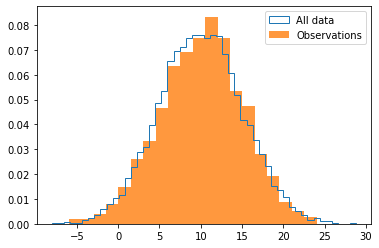

In [2]:
mu_true = 10
sigma_true = 5
data = np.random.normal(mu_true, sigma_true, 10000)
obs = np.random.choice(data, 1000, replace=False)

plt.hist(data, bins=50, label='All data', density=True, alpha=1, histtype='step')
plt.hist(obs, bins=20, label='Observations', density=True, alpha=0.8, histtype='stepfilled')
plt.legend()
plt.show()

<!--start-block-->
<hr style="height: 1px;">

## 13.3 Exercise 1


Now we will implement some of the moving parts of Metropolis-Hastings. 

1) First implement a likelihood function which takes in the parameters mu and sigma
and returns the likelihood of the observed data under those parameter values.
2) Implement a proposal distribution.

<br>
<!--end-block-->

In [4]:
def likelihood(x, mu, sigma):
    # Implement a likelihood function for the model used to generate the data
    # make sure to avoid multiplying very small numbers to avoid underflow
    # and compute the likelihood over the observed data
    return np.exp(-0.5*(x-mu)**2/sigma**2)/np.sqrt(2*np.pi*sigma**2)


# instead of defining the likelihood function, we can use stats.norm from scipy 
# which implements methods for all sorts of useful things like the pdf and cdf
def loglikelihood(mu, sigma):
    return sum(stats.norm.logpdf(obs, mu, sigma))

def transition_model(x):
    # Implement a symmetric transition model
    # Remember if the transition density is not symmetric, 
    # you will need to account for this term in the acceptance probability
    return np.random.randn() + x

def log_prior(mu, sigma):
    # Implement a uniform prior for mu
    # which does not change the acceptance probability

    # the prior for sigma is uniform over positive values
    log_prob = 0 if sigma > 0 else -np.inf
    return log_prob

In [5]:
def step(mu, sigma):
    # Implement a single step of the Markov chain
    # This function should return the new value of mu and sigma
    # and the loglikelihood of the new value
    return transition_model(mu), sigma, loglikelihood(mu, sigma)

def metro_hastings(mu, sigma, n_steps=1000, n_samples=0):
    samples = []
    samples_step = []
    markov_chain = []
    # Implement the Metropolis-Hastings algorithm
    i=0
    while len(samples) < n_samples or i < n_steps:
        # Take a step
        mu_new, _, log_likelihood = step(mu, sigma)
        # Acceptance probability
        prob = np.exp(min(0, loglikelihood(mu_new, sigma) - log_prior(mu_new, sigma))) # log_prior(mu_new, sigma) - log_prior(mu, sigma)
        if np.random.rand() < prob:
            mu = mu_new
            samples.append(mu_new)
            samples_step.append(i)
        i+=1
        markov_chain.append(mu)
    return samples, samples_step, markov_chain

Acceptance rate: 0.19470404984423675


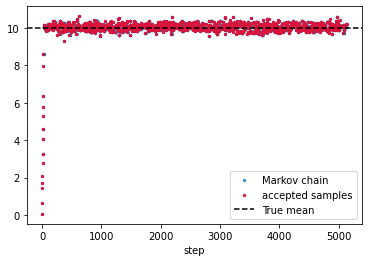

In [6]:
# Run your Metropolis-Hastings algorithm
# to generate 1000 samples
TOTAL_STEPS = 1000
samples, samples_step, markov_chain = metro_hastings(0, 5, TOTAL_STEPS, n_samples=1000)
# What is your acceptance rate?
# What determines this value? How can you make it larger?
# Hint: try changing your jumping distribution
print("Acceptance rate: {}".format(len(samples)/len(markov_chain)))

# Make some plots to visualize your markov chain with 
# both accepted and rejected proposals
# What happens in the early steps?
# This why there is a "burn-in" phase in MCMC methods.
plt.scatter(range(len(markov_chain)), markov_chain, label='Markov chain', alpha=0.8, s=5)
plt.scatter(samples_step, samples, label='accepted samples', color='crimson', s=5)
plt.axhline(10, color='black', linestyle='--', label='True mean')
plt.xlabel('step')
plt.legend()
plt.show()

In many cases we want to generate independent identically distributed samples.
Let's check if that's what we got.

The function plt.accor plots the correlation between samples at different distances $\tau$,
 $$C(\tau) = Corr(x_t,x_{t-\tau})$$
 at $\tau = 0$, $C(0)$ is always 1 since it's the correlation of a random variable with itself.

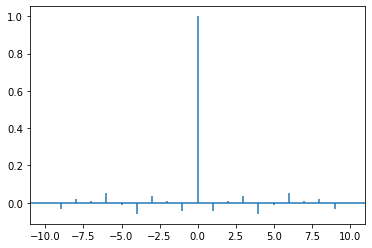

In [7]:
# Use plt.acorr to plot the autocorrelation of the samples you generated
# and compare that to a true i.i.d sample from a normal distribution (np.random.randn)
# Do you notice a problem?
x = np.random.randn(len(samples))
plt.acorr(x, maxlags=10)
plt.show()

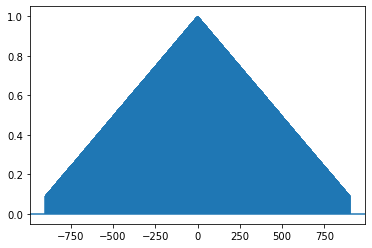

In [8]:
plt.acorr(samples, maxlags=900)
plt.show()

In [9]:
def transition_model(x):
    # Implement a symmetric transition model
    # Remember if the transition density is not symmetric, 
    # you will need to account for this term in the acceptance probability
    return np.random.randn()*0.1 + x

In [10]:
samples, _, mc = metro_hastings(0, 5, n_samples=10000)
print("Acceptance rate: {}".format(len(samples)/len(mc)))

Acceptance rate: 0.7971938775510204


<!--start-block-->
<hr style="height: 1px;">

## 13.3 Exercise 2


Now we will do some parameter estimation!
Hints:
The mean of the sample can be a good estimator.
A 95% credible interval (CI) is an interval which contains
the true value of the parameter $\theta$ with probability 0.95. 
You can find a few examples of ways to construct a CI here
https://en.wikipedia.org/wiki/Credible_interval
<br>
<!--end-block-->

Construct a 90% Credible Interval for the true mean using
the samples you generated from MCMC. You can use the function np.percentile from numpy
to compute the percentiles of the samples.


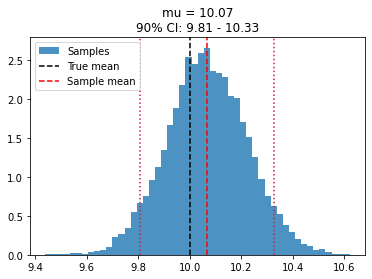

Mean estimate: 10.07 + 0.26 - -0.26


In [12]:
# Make a histogram of your samples (don't forget about burn-in)
# Plot your best estimate of the true mean
# along with the edges of your credible interval.
# Are the results reasonable?
# How can you have a "better" interval?
# Hint: Investigate how the number of observations affects
# your results.
plt.hist(samples[200:], bins=50, label='Samples', density=True, alpha=0.8, histtype='stepfilled')
plt.axvline(mu_true, color='black', linestyle='--', label='True mean')

percentiles = np.percentile(samples[200:], [5, 95])
mu_estimate = np.mean(samples[200:])

plt.axvline(mu_estimate, color='red', linestyle='--', label='Sample mean')
for p in percentiles:
    plt.axvline(p, color='crimson', linestyle=':')
plt.title(r'mu = {:.2f}'.format(mu_estimate) + '\n' + '90% CI: {:.2f} - {:.2f}'.format(percentiles[0], percentiles[1]))
plt.legend()
plt.show()
print(f"Mean estimate: {mu_estimate:.2f} + {percentiles[1]-mu_estimate:.2f} {percentiles[0]-mu_estimate:.2f}")

In [13]:
# What happens if you increase the number of observations?
obs = np.random.choice(data, len(data), replace=False)
samples, _, mc = metro_hastings(0, 5, n_samples=10000)
print("Acceptance rate: {}".format(len(samples)/len(mc)))

Acceptance rate: 0.5056122964910507


In [ ]:
# Optional: 
# Run the MCMC algorithm for both mu and sigma 
# and plot the mean and the 90% CI

# How can you make the MCMC algorithm more efficient?
# How can you make the samples indepdent?
# The answer can be found here: https://arxiv.org/pdf/2101.08176.pdf
# The key idea is that you can use "Normalizing Flows" to approximate
# the target distribution which you can then correct using Metropolis-Hastings
# to obtain an exact i.i.d sample of the target distribution. 